<img src="figuras/logo.png" alt="logo" style="max-width: 450px;display: block">

<h1 style="text-align: center; font-size: 3rem;">Processamento e interpretação de
dados de campos potenciais  </h1>

<h1 style="text-align: center; font-size: 2.0rem;">Redução ao polo via Camada equivalente (Reduction to the pole via equivalent layer)</h1>

## ℹ️ Sobre este tutorial

***Este código ilustra como calcular RTP usando a técnica da camada equivalente, de anomalias de campo total produzidas por prismas retangulares homogêneos .***

## 🐍 Importe as bibliotecas necessárias

In [1]:
import numpy as np
import pyvista as pv # pacote de plotagem 3D
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab

In [2]:
from codes import functions as func
from codes import plot_functions as plf
from codes import plot_function_pyvista as plv
from codes import prism

In [3]:
from codes.gravmag.models import rectangular_prism as rp

In [4]:
from codes.gravmag import filters, convolve, transforms

In [5]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 150

### Pontos onde calculamos os dados sintéticos

In [6]:
shape = (50, 50)

# Oeste, Leste, Sul, Norte
area = [-5000, 5000, -5000, 6000]

# espaçamento do grid
dx = (area[1] - area[0])/(shape[0]-1)
dy = (area[3] - area[2])/(shape[1]-1)

# coordenadas dos pontos de observação 
y = np.linspace(area[0], area[1], shape[0])
x = np.linspace(area[2], area[3], shape[1])

y, x = np.meshgrid(y, x)

y = np.ravel(y)
x = np.ravel(x)
z = np.zeros_like(y) -150

coordinates = np.vstack([y, x, z])

### Cria modelo formado por prismas

In [7]:
# prismas = [Oeste, Leste, Sul, Norte, Topo, Base]
prismas = np.array([[2000., 3000., -1500., -500.,10.,200.], 
                    [1600., 2600., -2500., -1500.,10.,200.], 
                    [-5000., 5000., 1500., 2500.,10.,200.],
                    [-3000., -2000., -4000., 1500.,10.,200.]])

### Magnetização de cada prisma a primeira, segunda e terceira colunas contêm a intensidade de magnetização (em A/m), inclinação e declinação (em graus) das fontes

In [8]:
magnetization = np.array([[1.4, 30, -10],
                          [1.3, 30, -10],
                          [1.1, 60, 40],
                          [1.2, -20, -75]])

### Magnetização usada para calcular RTP verdadeira,  a primeira, segunda e terceira colunas contêm a intensidade de magnetização (em A/m), inclinação e declinação (em graus) das fontes

In [9]:
magnetization_vertical = np.array([[1.4, 90, 0],
                                   [1.3, 90, 0],
                                   [1.1, 90, 0],
                                   [1.2, 90, 0]])

### Campo principal 

In [10]:
# reference point
yc, xc = 0, 1000

# inclination (degrees)
I0 = 6 - 1e-4*(x-xc) + 3e-4*(y-yc) + 1e-8*(x-xc)*(x-xc) + 1e-8*(y-yc)*(y-yc)

# declination (degrees)
D0 = 45 + 6e-5*(x-xc) + 1e-4*(y-yc) + 3e-9*(x-xc)*(x-xc) + 4e-9*(y-yc)*(y-yc)

# intensity (nT)
F0 = 23400 + 1e-4*(x-xc) + 1e-4*(y-yc) + 0*(x-xc)*(x-xc) + 0*(y-yc)*(y-yc)

# Cartesian components of the main field
cosI0 = np.cos(np.deg2rad(I0))
sinI0 = np.sin(np.deg2rad(I0))
cosD0 = np.cos(np.deg2rad(D0))
sinD0 = np.sin(np.deg2rad(D0))
Fx = F0*cosI0*cosD0
Fy = F0*cosI0*sinD0
Fz = F0*sinI0

### Dados sintéticos

In [11]:
# Compute the magnetic field components
bx = prism.mag(coordinates=coordinates, prisms=prismas, magnetization=magnetization, field='b_x')
by = prism.mag(coordinates=coordinates, prisms=prismas, magnetization=magnetization, field='b_y')
bz = prism.mag(coordinates=coordinates, prisms=prismas, magnetization=magnetization, field='b_z')

# Add a noise to the synthetic data
bx += np.random.normal(loc=0, scale=5, size=bx.size)
by += np.random.normal(loc=0, scale=5, size=by.size)
bz += np.random.normal(loc=0, scale=5, size=bz.size)

# Compute the total-field anomaly
tfa = np.sqrt((Fx+bx)**2 + (Fy+by)**2 + (Fz+bz)**2) - F0

# Compute the approximated total-field anomaly
mean_I0 = np.mean(I0)
mean_D0 = np.mean(D0)
cos_mean_I0 = np.cos(np.deg2rad(mean_I0))
sin_mean_I0 = np.sin(np.deg2rad(mean_I0))
cos_mean_D0 = np.cos(np.deg2rad(mean_D0))
sin_mean_D0 = np.sin(np.deg2rad(mean_D0))
Fx_hat = cos_mean_I0*cos_mean_D0
Fy_hat = cos_mean_I0*sin_mean_D0
Fz_hat = sin_mean_I0

approx_tfa = Fx_hat*bx + Fy_hat*by + Fz_hat*bz
diff_tfa = approx_tfa - tfa

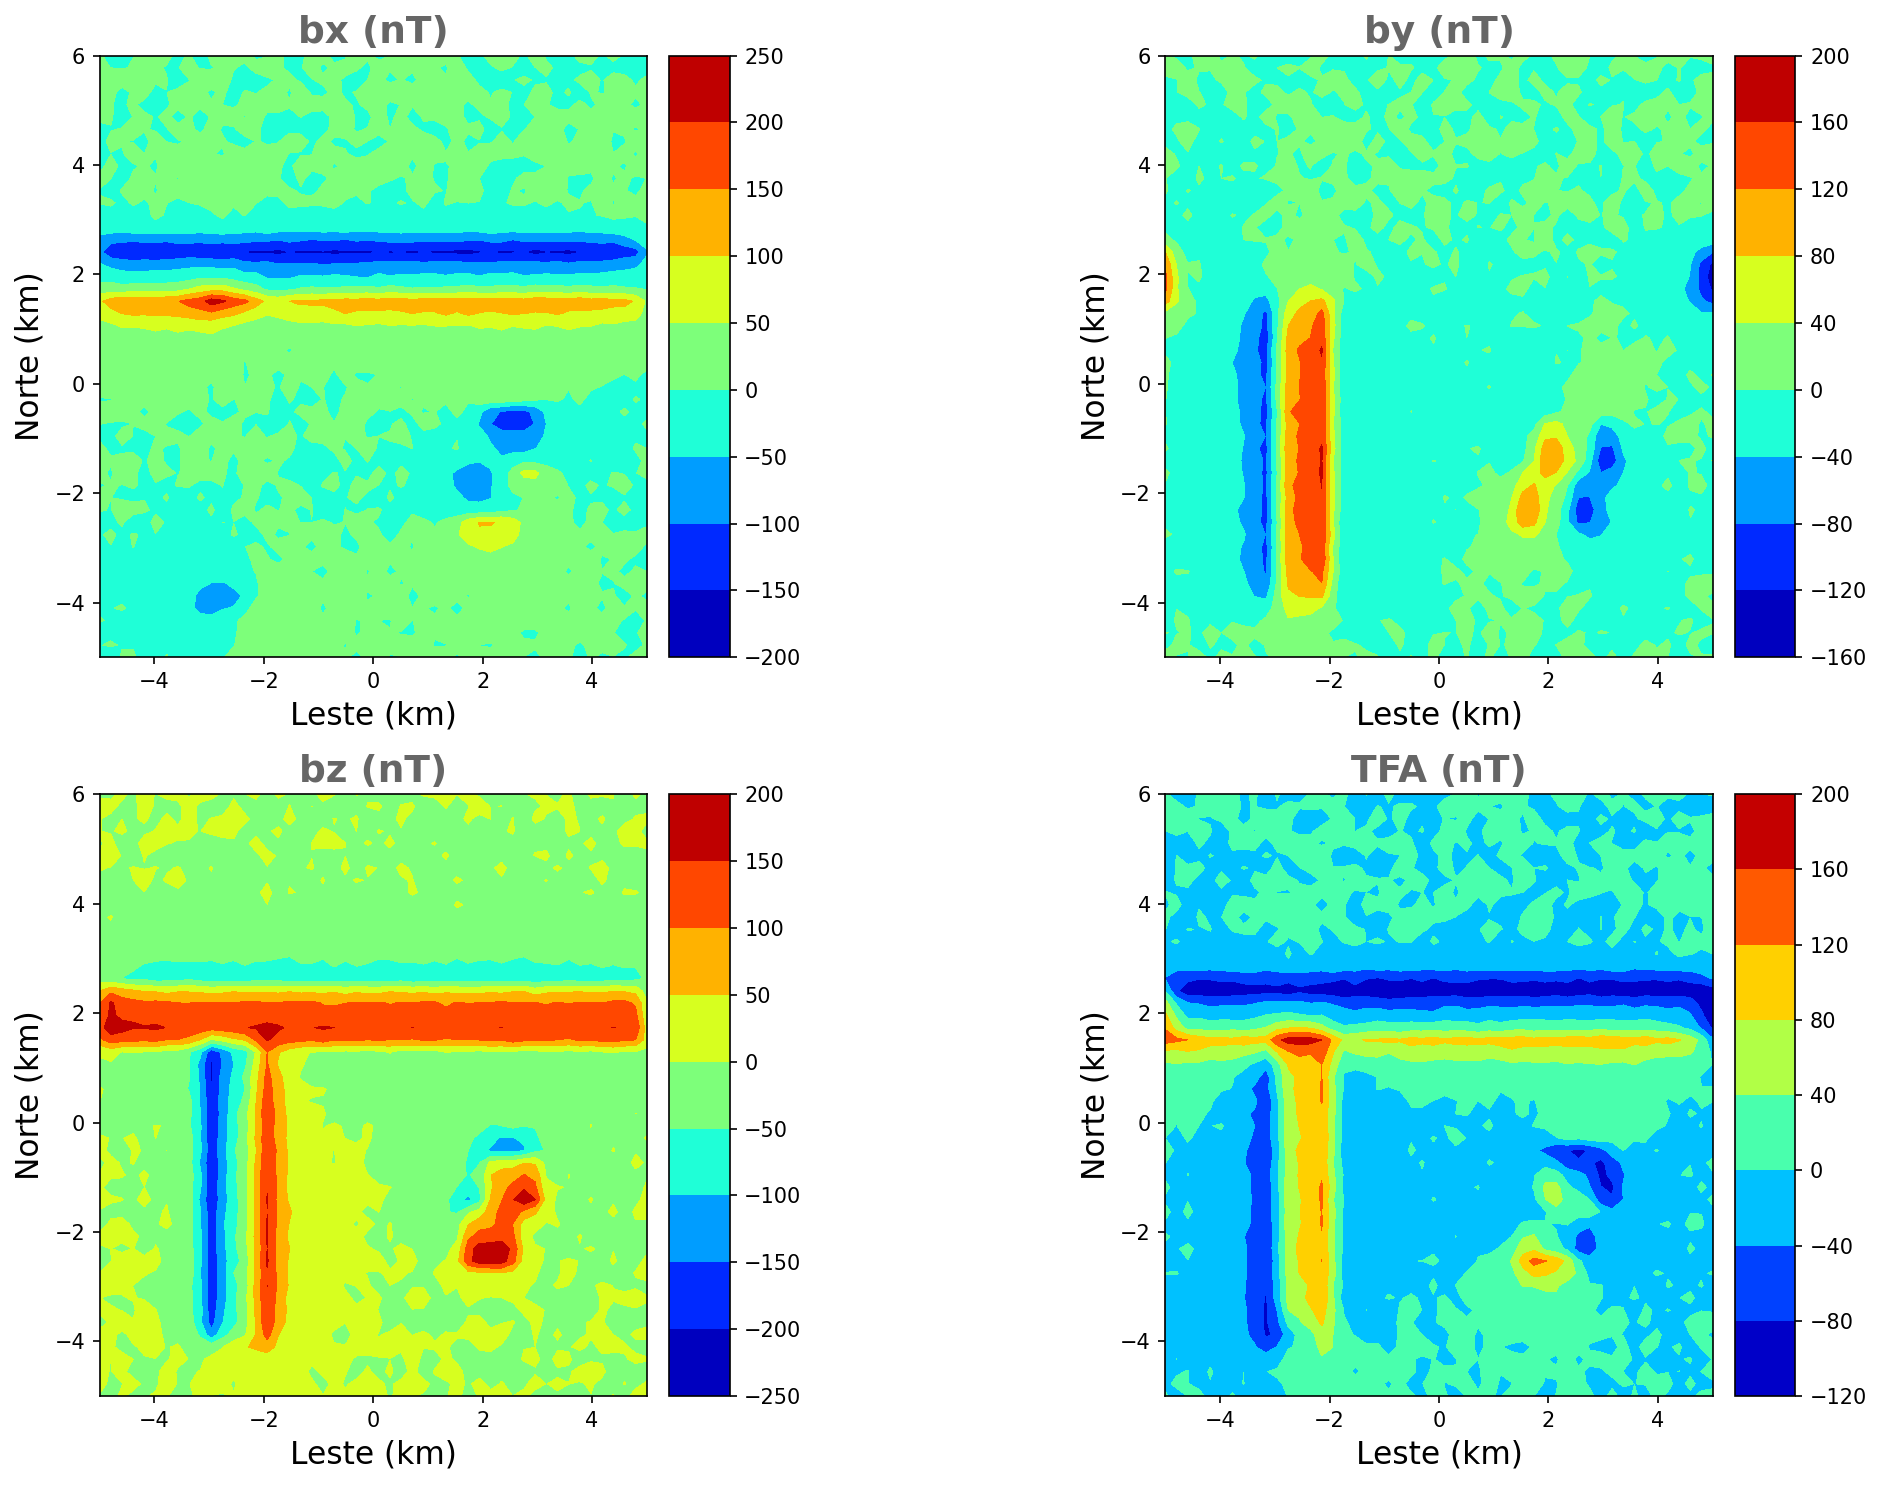

In [12]:
fields = [bx, by, bz, tfa]
windows = [1, 2, 3, 4]
titles = ['bx (nT)', 'by (nT)', 'bz (nT)', 'TFA (nT)']

plt.figure(figsize=(15,10))

for w, window in enumerate(windows):

    plt.subplot(2,2,window)
    plt.title(titles[w], fontsize=18,weight='bold', alpha=.6)
    plt.axis('scaled')
    plt.contourf(y.reshape(shape)*0.001, 
                 x.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='jet')
    plt.colorbar(shrink=1.0, pad=0.02, aspect=10)
#     plf.model_boundaries_2(prismas, m2km=True,linewidth = 2)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('Leste (km)', fontsize=15)
    plt.ylabel('Norte (km)', fontsize=15)

plt.tight_layout()
plt.savefig('figuras/notebook-4/TFA.png',dpi = 500, bbox_inches = 'tight')
plt.show()

###  TFA reduzido ao polo 

In [13]:
# Calcula uma TFA verdadeita RTP
rtp_anomaly = prism.mag(coordinates=coordinates,
                        prisms=prismas,
                        magnetization=magnetization_vertical,
                        field='b_z')

rtp_anomaly += np.random.normal(loc=0, scale=5, size=rtp_anomaly.size)

### Plot da TFA verdadeira e TFA reduzido ao polo

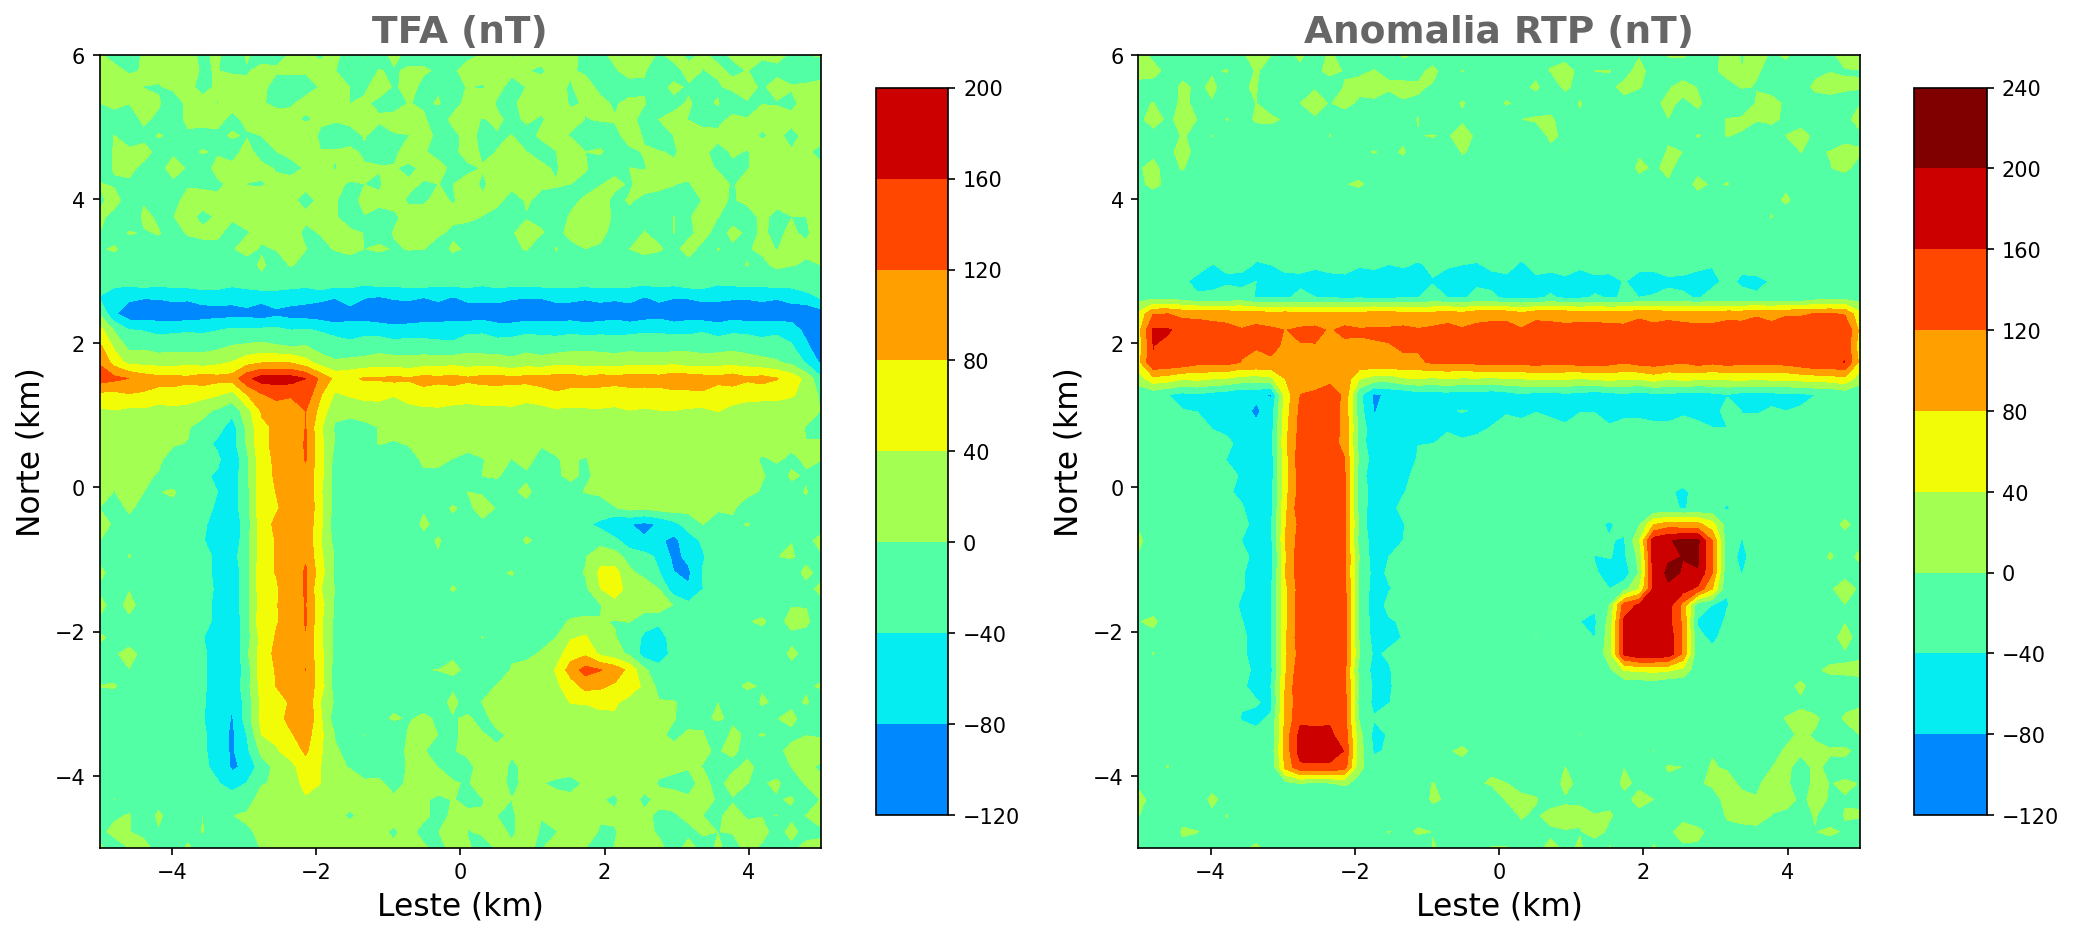

In [14]:
fields = [tfa, rtp_anomaly]
windows = [1, 2]
titles = ['TFA (nT)', 'Anomalia RTP (nT)',]
ranges = np.max(np.abs([tfa, rtp_anomaly]))


plt.figure(figsize=(14,10))

for w, window in enumerate(windows):

    plt.subplot(1,2,window)
    plt.title(titles[w], fontsize=18,weight='bold', alpha=.6)
    plt.axis('scaled')
    plt.contourf(y.reshape(shape)*0.001, 
                 x.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='jet',vmin = -ranges, vmax = ranges)
    
    plt.colorbar(shrink=0.5, pad=0.06, aspect=10)
#     plf.model_boundaries_2(prismas, m2km=True,linewidth = 2)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('Leste (km)', fontsize=15)
    plt.ylabel('Norte (km)', fontsize=15)

plt.tight_layout()
plt.savefig('figuras/notebook-4/TFA_TFA-RTP.png',dpi = 500, bbox_inches = 'tight')
plt.show()

 ## RTP via Camada equivalente 

### Construção de uma camada equivalente

In [15]:
shape_eql = (50, 50)

# Oeste, Leste, Sul, Norte
area_eql = [-5000, 5000, -5000, 6000]

# espaçamento do grid
dx_eql = (area_eql[1] - area_eql[0])/(shape_eql[0]-1)
dy_eql = (area_eql[3] - area_eql[2])/(shape_eql[1]-1)

y_eql,x_eql = func.grid_point(area_eql,shape_eql)
z_eql = np.zeros_like(y_eql) -100

In [16]:
# Camada formada por um conjunto de prismas 
prismas_eql = func.build_model(x_eql,y_eql,z_eql+200,dz=500)

### Plot 3D da camada de prismas

### Magnetização da camada de prismas 

In [17]:
#A camada equivalente é formada por dipolos com a mesma direção
#de magnetização do campo principal
inclinação_eql = I0
declinação_eql = D0
intensidade_eql = F0

In [18]:
magnetização_eql = np.zeros((prismas_eql.shape[0],3))
magnetização_eql[:,0] = intensidade_eql
magnetização_eql[:,1] = inclinação_eql
magnetização_eql[:,2]= declinação_eql

### Magnetização vertical de camada de prismas usada para o calculo da anomalia RTP

In [19]:
magnetização_eql_rtp = np.zeros((prismas_eql.shape[0],3))
magnetização_eql_rtp[:,0] = intensidade_eql
magnetização_eql_rtp[:,1] = 90
magnetização_eql_rtp[:,2]= 0

### Função que calcula a curva L, para a escolha parâmetro de regularização mais adequado para ser usado na inversão dos dados de TFA

In [20]:
def lcurve(A,ATA,ATd,f,mu_list,data):

    pTp_list = []
    misfit_list = []

    for mu in mu_list:
        p_hat = np.linalg.solve(ATA+(mu*f)*np.identity(A.shape[1]),ATd) 
        data_hat = np.dot(A,p_hat)
        pTp_list.append(np.sum(p_hat*p_hat)) 
        residual_data = data - data_hat
        misfit_list.append(np.sum(residual_data*residual_data))
    
    return pTp_list,misfit_list

### Calculo da matriz sensibilidade 

In [21]:
# Matriz sensibilidade usada para o calcula da tfa predita 
A = func.sensitivity_matrix(coordinates,prismas_eql,magnetização_eql,I0, D0)
# Matriz sensibilidade usada para o calcula da tfa predita RTP
A_rtp = func.sensitivity_matrix(coordinates,prismas_eql,magnetização_eql_rtp,I0, D0)

In [22]:
A.shape #(N x M)

(2500, 2500)

### Curva L

In [23]:
ATA = A.T@A
diag_ATA = ATA.diagonal()
ATd = A.T@tfa
f = (np.sum(diag_ATA))/(A.shape[1]) #fator normalizante

In [24]:
mu_list = [1e-1,8e-2,5e-2,1e-2,1e-3,7e-4,4e-4,1e-4,5e-5,
           3e-5,1e-5,9e-6,5e-6,1e-6,1e-7,1e-8,1e-9,1e-10]

In [25]:
pTp,misfit = lcurve(A,ATA,ATd,f,mu_list,tfa)

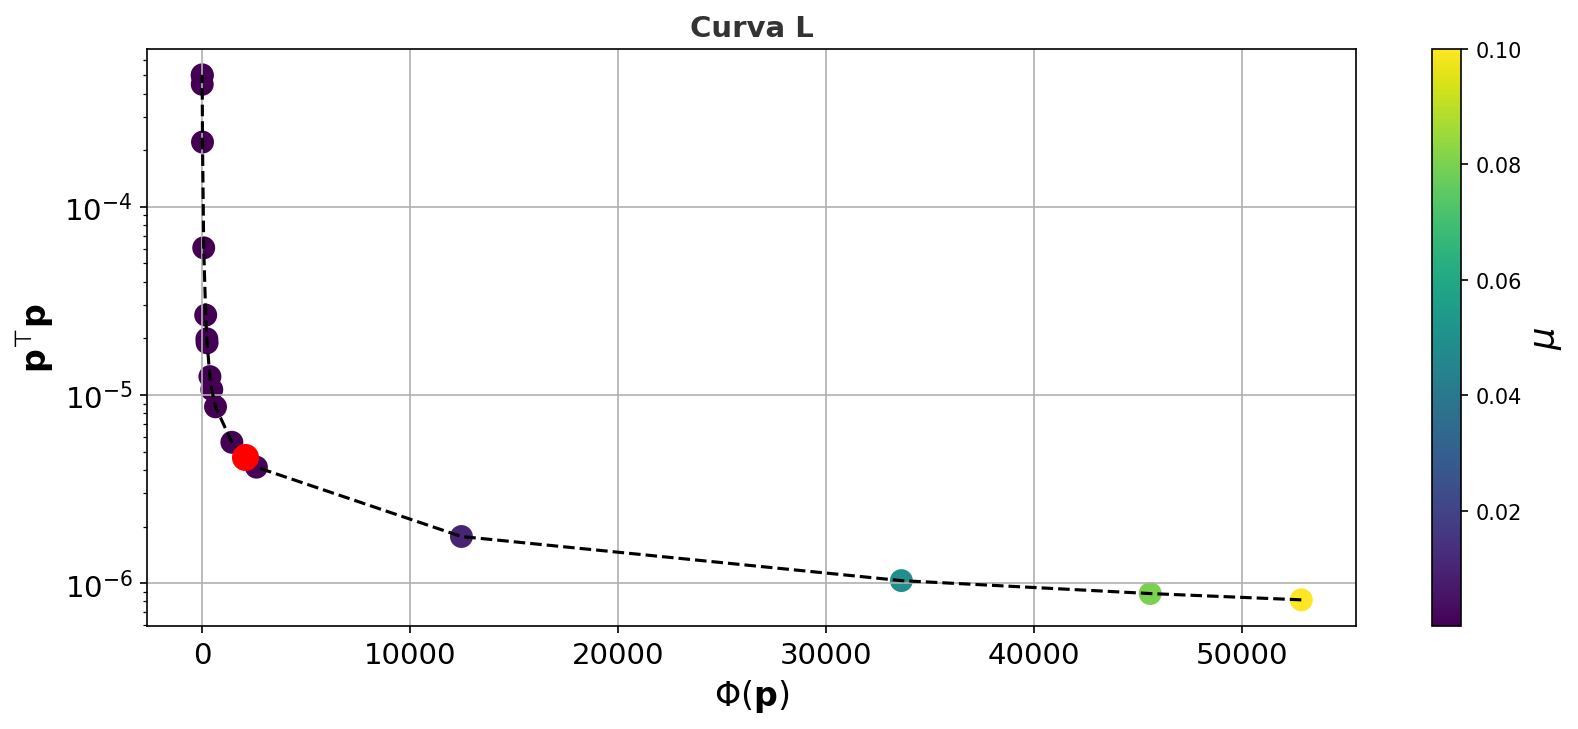

In [26]:
plt.figure(figsize=(13,5))
plt.plot(misfit,pTp,'k--')
plt.scatter(misfit,pTp,s=100,c=mu_list,marker='o')
cbar = plt.colorbar()
cbar.set_label('$\mu$',fontsize =17)
plt.plot(misfit[5],pTp[5],'ro',markersize=12) 
plt.title('Curva L', fontsize=14,weight='bold', alpha=.8)
plt.xlabel('$\Phi(\mathbf{p})$',fontsize =16)
plt.ylabel('$\mathbf{p}^{\\top}\mathbf{p}$',fontsize =16)
plt.xticks(fontsize =14)
plt.yticks(fontsize =14)
plt.grid()
# plt.xscale('log')
plt.yscale('log')
#plt.text(0.8,5,'$\mu=1e-2$',color='k',weight='bold',fontsize=1
# plt.savefig('figures/Lcurve_z0.png')
plt.show()

In [27]:
mu = mu_list[5]
print(mu)

0.0007


In [28]:
p = np.linalg.solve(ATA+(mu*f)*np.identity(A.shape[1]),ATd)

In [29]:
tfa_predita = np.dot(A,p)
residuo_tfa = tfa_predita - tfa

### Plot da TFA verdadeira $\times$ TFA predita

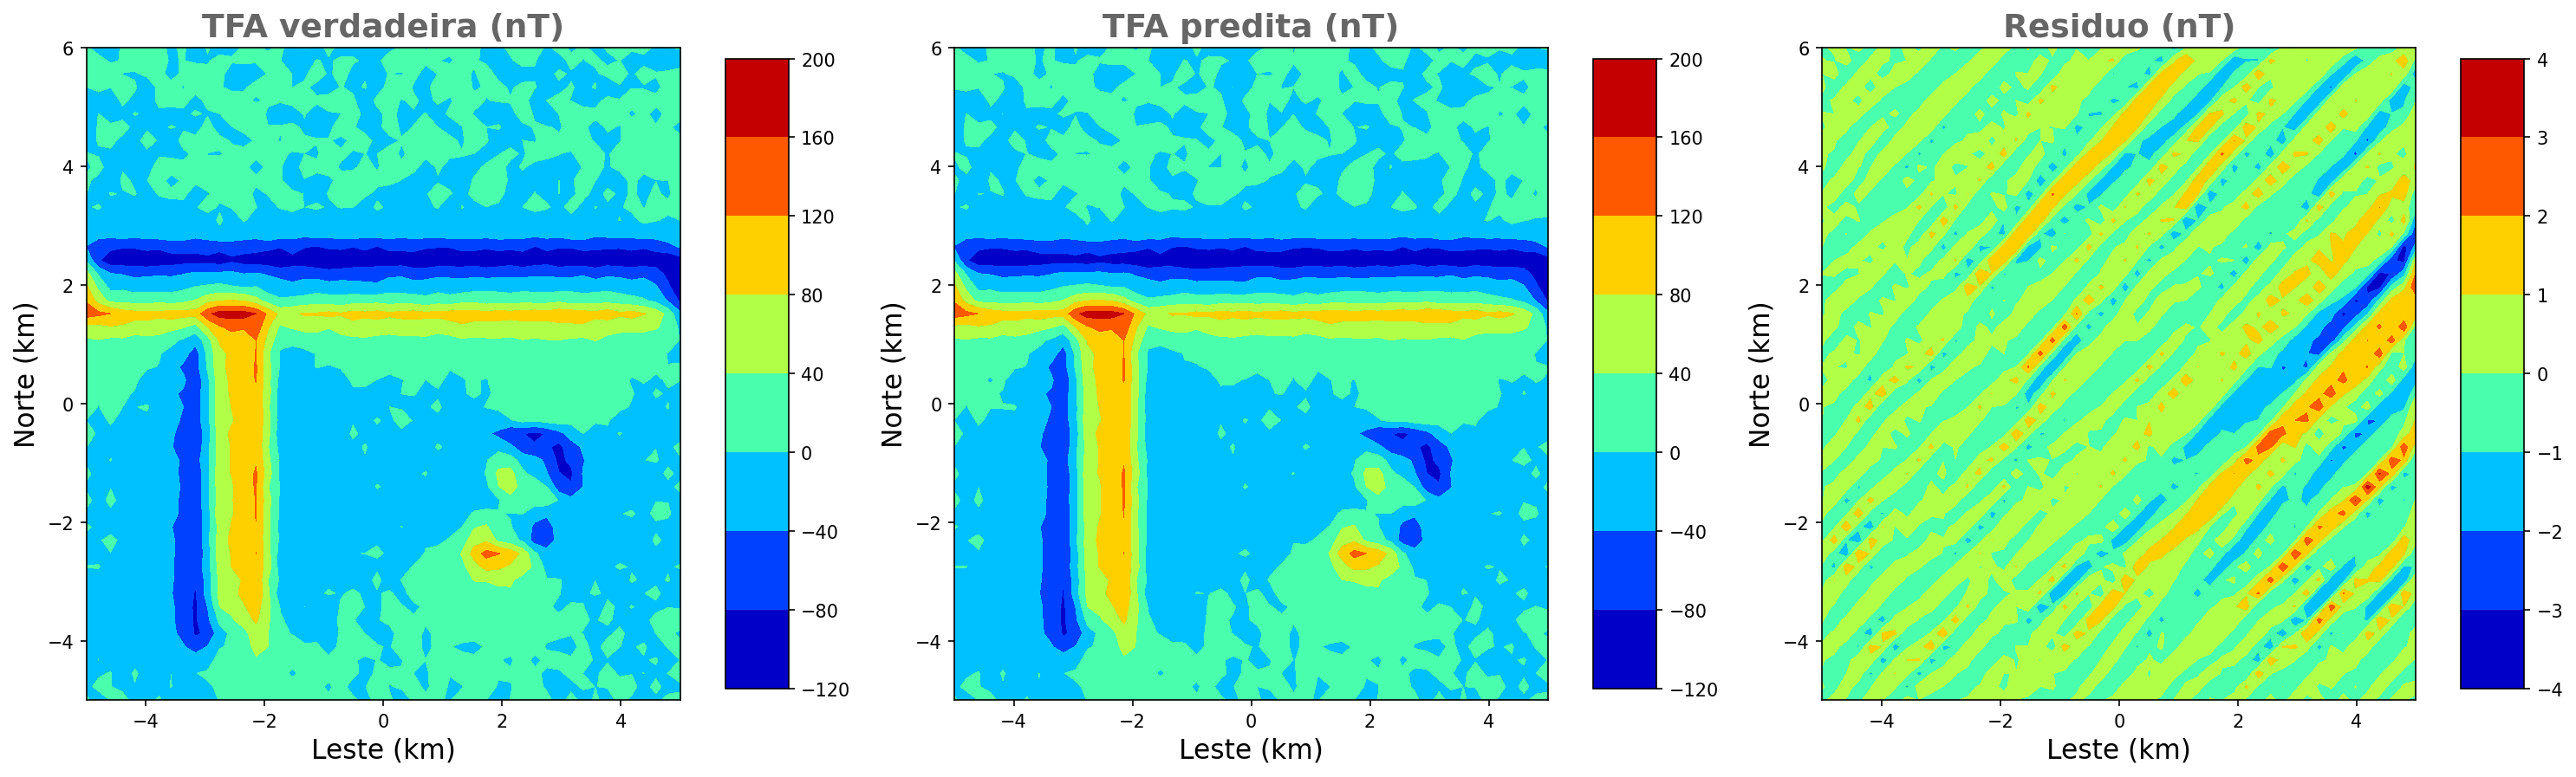

In [30]:
fields = [tfa, tfa_predita, residuo_tfa]
windows = [1, 2, 3]
titles = ['TFA verdadeira (nT)', 'TFA predita (nT)', 'Residuo (nT)']

plt.figure(figsize=(20,10))

for w, window in enumerate(windows):

    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=18,weight='bold', alpha=.6)
    plt.axis('scaled')
    plt.contourf(y.reshape(shape)*0.001, 
                 x.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='jet')
    
    plt.colorbar(shrink=0.5, pad=0.06, aspect=10)
#     plf.model_boundaries_2(prismas, m2km=True,linewidth = 2)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('Leste (km)', fontsize=15)
    plt.ylabel('Norte (km)', fontsize=15)

plt.tight_layout()
plt.savefig('figuras/notebook-4/TFA_predito.png',dpi = 500, bbox_inches = 'tight')

plt.show()

### Curva L - anomalia RTP

In [31]:
ATA_rtp = A_rtp.T@A_rtp
diag_ATA_rtp = ATA_rtp.diagonal()
ATd_rtp = A_rtp.T@rtp_anomaly
f_rtp = (np.sum(diag_ATA_rtp))/(A_rtp.shape[1]) #fator normalizante

In [32]:
pTp_rtp,misfit_rtp = lcurve(A_rtp,ATA_rtp,ATd_rtp,f_rtp,mu_list,rtp_anomaly)

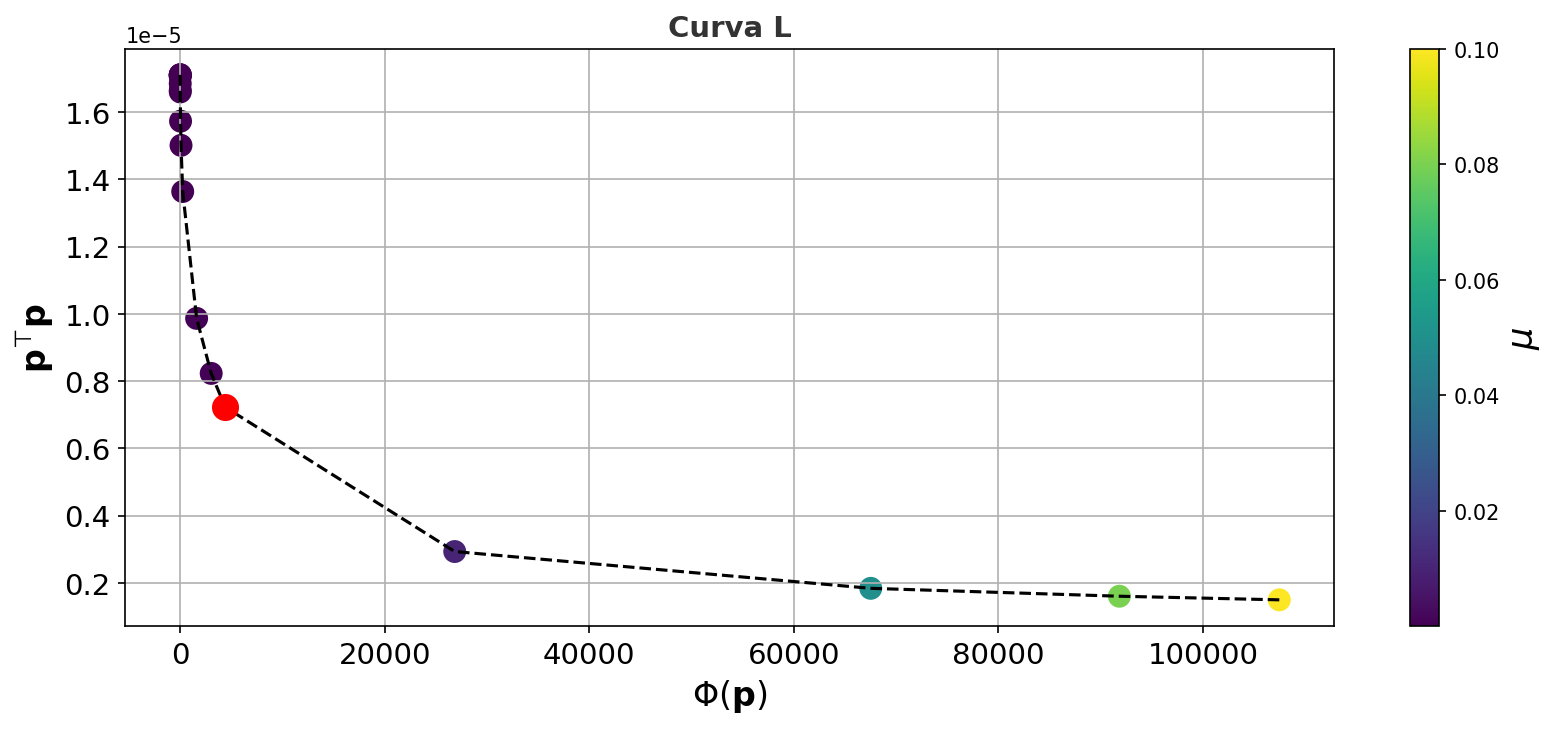

In [33]:
plt.figure(figsize=(13,5))
plt.plot(misfit_rtp,pTp_rtp,'k--')
plt.scatter(misfit_rtp,pTp_rtp,s=100,c=mu_list,marker='o')
cbar = plt.colorbar()
cbar.set_label('$\mu$',fontsize =17)
plt.plot(misfit_rtp[4],pTp_rtp[4],'ro',markersize=12)
plt.title('Curva L', fontsize=14,weight='bold', alpha=.8)
plt.xlabel('$\Phi(\mathbf{p})$',fontsize =16)
plt.ylabel('$\mathbf{p}^{\\top}\mathbf{p}$',fontsize =16)
plt.xticks(fontsize =14)
plt.yticks(fontsize =14)
plt.grid()
# plt.xscale('log')
# plt.yscale('log')
#plt.text(0.8,5,'$\mu=1e-2$',color='k',weight='bold',fontsize=1
# plt.savefig('figures/Lcurve_z0.png')
plt.show()

In [34]:
mu_rtp = mu_list[4]
print(mu_rtp)

0.001


In [35]:
p_rtp = np.linalg.solve(ATA_rtp+(mu_rtp*f_rtp)*np.identity(A_rtp.shape[1]),ATd_rtp)

In [36]:
tfa_predita_rtp = np.dot(A_rtp,p_rtp)
residuo_rtp = tfa_predita_rtp - rtp_anomaly

### Plot da TFA verdadeira RTP $\times$ TFA predita RTP

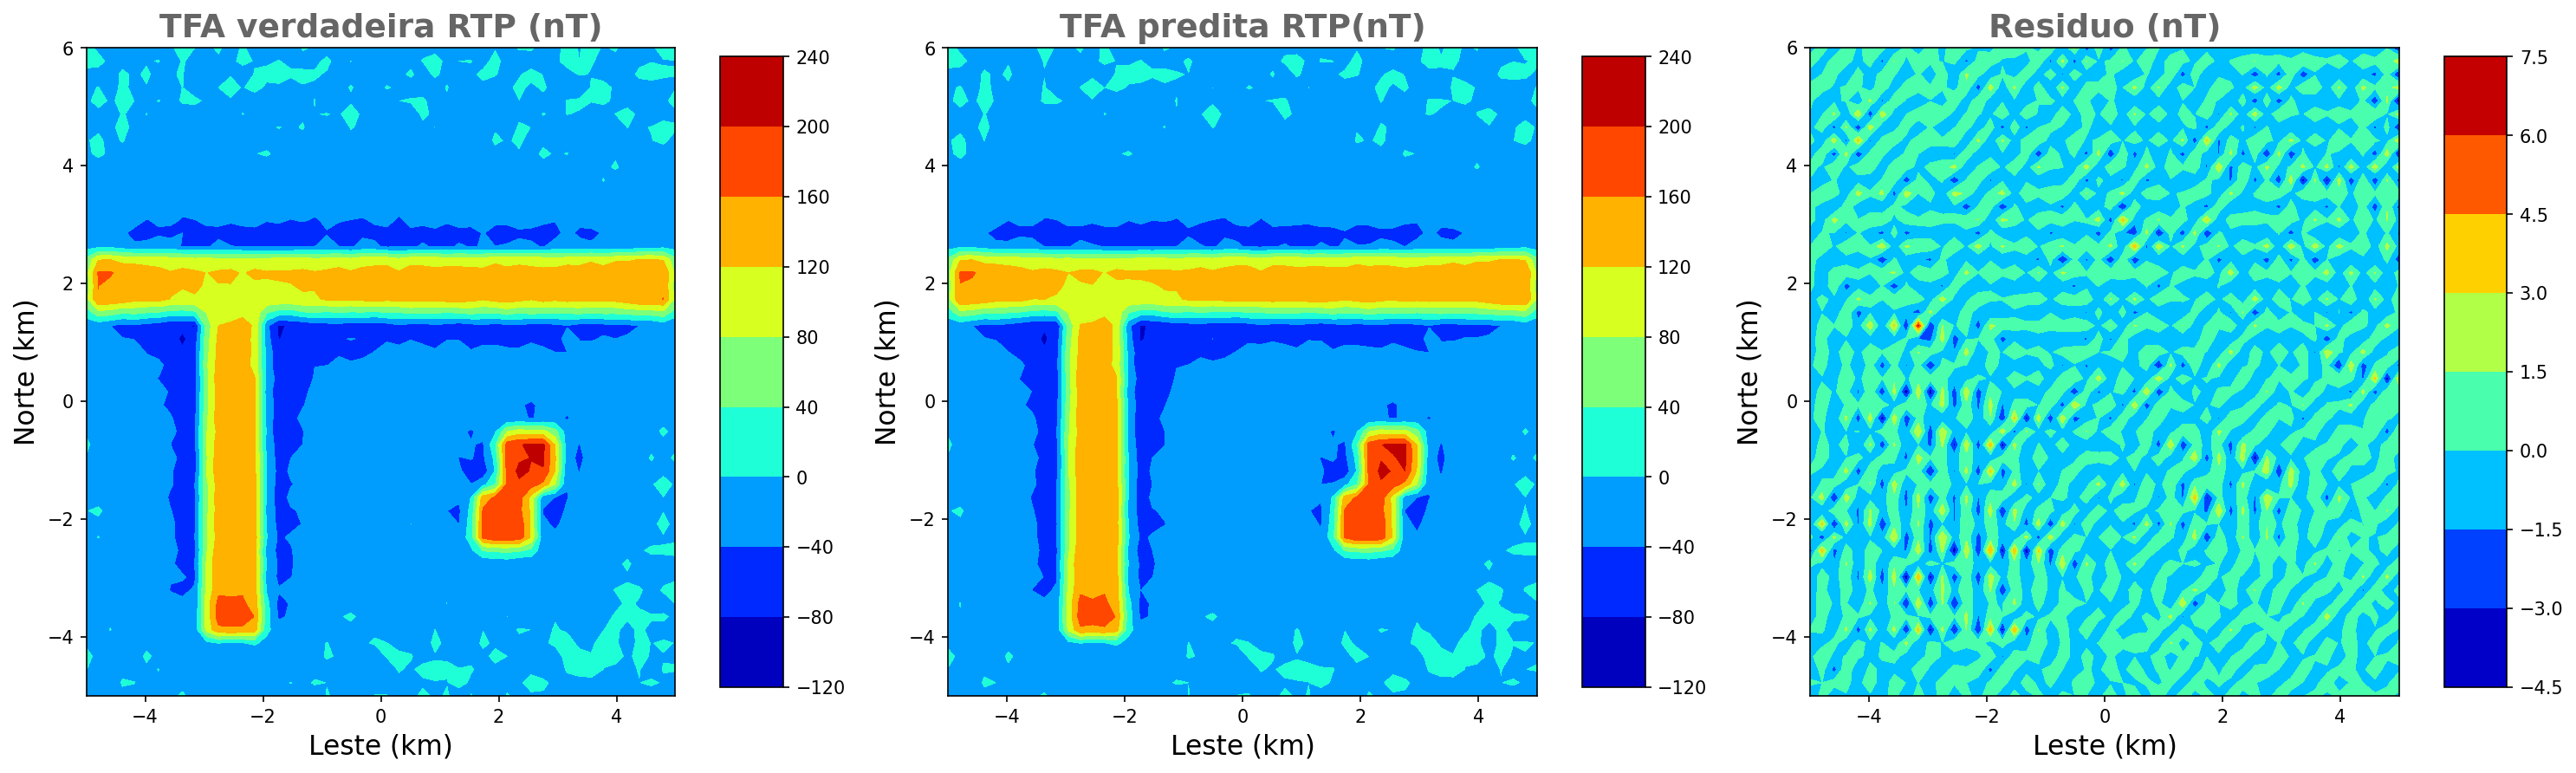

In [40]:
fields = [rtp_anomaly, tfa_predita_rtp, residuo_rtp]
windows = [1, 2, 3]
titles = ['TFA verdadeira RTP (nT)', 'TFA predita RTP(nT)', 'Residuo (nT)']

plt.figure(figsize=(20,10))

for w, window in enumerate(windows):

    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=18,weight='bold', alpha=.6)
    plt.axis('scaled')
    plt.contourf(y.reshape(shape)*0.001, 
                 x.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='jet')
    
    plt.colorbar(shrink=0.5, pad=0.06, aspect=10)
#     plf.model_boundaries_2(prismas, m2km=True,linewidth = 2)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('Leste (km)', fontsize=15)
    plt.ylabel('Norte (km)', fontsize=15)

plt.tight_layout()
plt.savefig('figuras/notebook-4/TFA-RTP_predito.png',dpi = 500, bbox_inches = 'tight')
plt.show()

## Ajustando uma distribuição normal a dados 1D

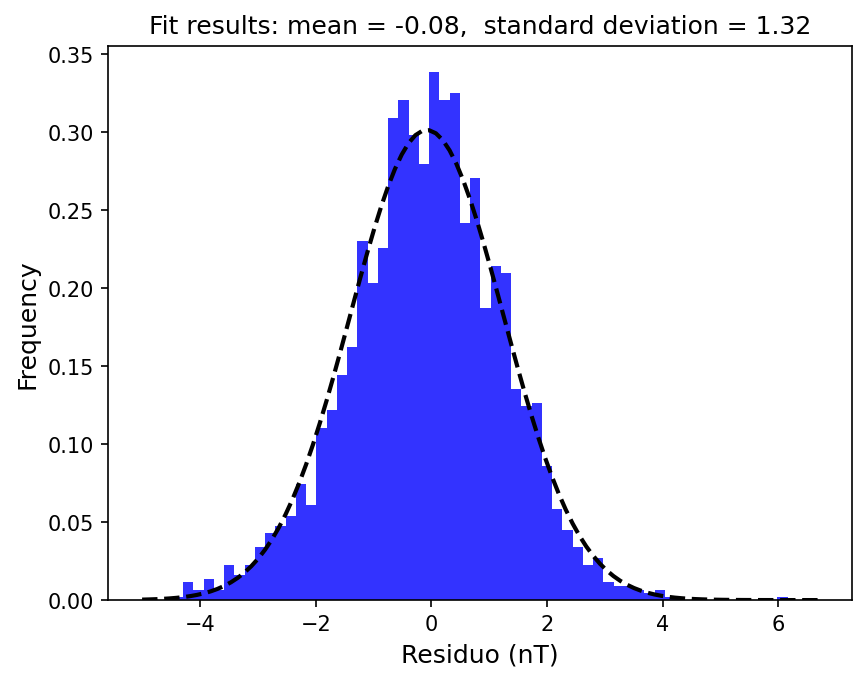

In [41]:
# Fit a normal distribution to the data:
mu, std = norm.fit(residuo_rtp)

# Plot the histogram.
# plt.figure(figsize=(8,4))
weights = np.ones_like(residuo_rtp) / len(residuo_rtp)
plt.hist(residuo_rtp,weights=weights, bins=60, density=True, alpha=0.8, color='blue')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k--', linewidth=2)
title = "Fit results: mean = %.2f,  standard deviation = %.2f" % (mu, std)
plt.title(title)

plt.xlabel('Residuo (nT)' , fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.savefig('figuras/notebook-4/normal_distribution.png',dpi = 500, bbox_inches = 'tight')
plt.show()